In [1]:
import torch
import numpy as np
from PIL import Image
import torchvision


class Dataset(torch.utils.data.Dataset):
    def __init__(self, part):
        self.part = part
        self.data = np.loadtxt(fname='data/pika/%s.csv' % part, delimiter=',')

        #数据增强模块,这里不需要什么太高级的变化
        self.transforms = torchvision.transforms.ToTensor()

    def __getitem__(self, idx):
        image = Image.open('data/pika/%s/%s.jpg' % (self.part, idx))
        image = self.transforms(image)

        target = {
            'labels': torch.LongTensor([1]),
            'boxes': torch.LongTensor([self.data[idx] * 256])
        }

        return image, target

    def __len__(self):
        return len(self.data)


def collate_fn(data):
    images = [i[0] for i in data]
    targets = [i[1] for i in data]
    return images, targets


loader = torch.utils.data.DataLoader(dataset=Dataset(part='train'),
                                     batch_size=8,
                                     shuffle=True,
                                     drop_last=True,
                                     collate_fn=collate_fn)

for i, (images, targets) in enumerate(loader):
    break

print(len(loader), type(images), type(targets), len(images), len(targets))

images[0], images[0].dtype, images[0].shape, targets[0]

116 <class 'list'> <class 'list'> 8 8


/root/anaconda3/envs/tt/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/torch/csrc/utils/tensor_new.cpp:201.)


(tensor([[[0.7098, 0.7176, 0.7294,  ..., 0.4000, 0.4000, 0.4000],
          [0.7137, 0.7176, 0.7255,  ..., 0.4000, 0.4000, 0.4000],
          [0.7216, 0.7176, 0.7176,  ..., 0.4000, 0.4000, 0.4000],
          ...,
          [0.4314, 0.4353, 0.4353,  ..., 0.4196, 0.4235, 0.4431],
          [0.4078, 0.4196, 0.4353,  ..., 0.3765, 0.3725, 0.3882],
          [0.4235, 0.4157, 0.4078,  ..., 0.4039, 0.3647, 0.3333]],
 
         [[0.7765, 0.7843, 0.7882,  ..., 0.6275, 0.6275, 0.6275],
          [0.7804, 0.7804, 0.7843,  ..., 0.6275, 0.6275, 0.6275],
          [0.7843, 0.7804, 0.7804,  ..., 0.6275, 0.6275, 0.6275],
          ...,
          [0.4235, 0.4275, 0.4353,  ..., 0.3804, 0.3843, 0.4118],
          [0.4000, 0.4196, 0.4353,  ..., 0.3373, 0.3333, 0.3490],
          [0.4157, 0.4157, 0.4078,  ..., 0.3647, 0.3255, 0.2941]],
 
         [[0.8392, 0.8471, 0.8627,  ..., 0.8078, 0.8078, 0.8078],
          [0.8431, 0.8431, 0.8588,  ..., 0.8078, 0.8078, 0.8078],
          [0.8471, 0.8431, 0.8431,  ...,

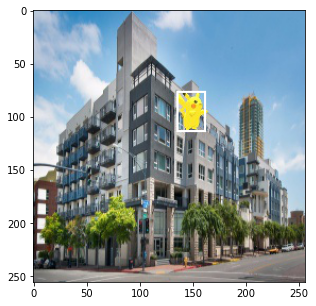

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import PIL.Image
import PIL.ImageDraw


#画出anchor
def show(image, target, out):
    image = image.detach().numpy() * 255.0
    image = image.astype(np.uint8)

    #(3, 256, 256) -> (256, 256, 3)
    image = image.transpose((1, 0, 2))
    image = image.transpose((0, 2, 1))

    target = target.detach().tolist()

    image = PIL.Image.fromarray(image)
    draw = PIL.ImageDraw.Draw(image)

    draw.rectangle(xy=target, outline='white', width=2)

    if out and len(out['scores']) > 0:
        idx = out['scores'].argmax().item()
        draw.rectangle(xy=out['boxes'][idx].tolist(), outline='black', width=2)

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()


show(images[0], targets[0]['boxes'][0], None)

In [3]:
class Backbone(torch.nn.Module):
    def __init__(self):
        super().__init__()

        vgg = torchvision.models.vgg.__dict__['vgg16'](
            pretrained=False).features

        vgg.load_state_dict(
            torch.hub.load_state_dict_from_url(
                'https://download.pytorch.org/models/vgg16_features-amdegroot.pth'
            ))

        #卷积结果的尺寸向上取整
        vgg[16].ceil_mode = True

        self.backbone = torch.nn.ModuleList([
            #以23层为分界,把vgg拆分成头尾两部分
            #vgg头部直接计算,作为第一部分的特征图
            torch.nn.Sequential(*vgg[:23]),

            #vgg尾部把最后一层剪掉,接上一个fc层,作为第二部分的特征图
            torch.nn.Sequential(
                *vgg[23:-1],
                torch.nn.Sequential(
                    torch.nn.MaxPool2d(kernel_size=3,
                                       stride=1,
                                       padding=1,
                                       ceil_mode=False),
                    torch.nn.Conv2d(in_channels=512,
                                    out_channels=1024,
                                    kernel_size=3,
                                    padding=6,
                                    dilation=6),
                    torch.nn.ReLU(inplace=True),
                    torch.nn.Conv2d(in_channels=1024,
                                    out_channels=1024,
                                    kernel_size=1),
                    torch.nn.ReLU(inplace=True),
                )),

            #额外加入4层,分别是不同尺度的特征.
            torch.nn.Sequential(
                torch.nn.Conv2d(1024, 256, kernel_size=1),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2),
                torch.nn.ReLU(inplace=True),
            ),
            torch.nn.Sequential(
                torch.nn.Conv2d(512, 128, kernel_size=1),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
                torch.nn.ReLU(inplace=True),
            ),
            torch.nn.Sequential(
                torch.nn.Conv2d(256, 128, kernel_size=1),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(128, 256, kernel_size=3),
                torch.nn.ReLU(inplace=True),
            ),
            torch.nn.Sequential(
                torch.nn.Conv2d(256, 128, kernel_size=1),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(128, 256, kernel_size=3),
                torch.nn.ReLU(inplace=True),
            )
        ])

    def forward(self, x):
        features = []
        for block in self.backbone:
            x = block(x)
            features.append(x)

        #normalize的等价计算
        #denom = x.norm(2.0, 1, keepdim=True).clamp_min(1e-12).expand_as(x)
        #x = x / denom
        features[0] = torch.nn.functional.normalize(features[0]) * 20

        return features


features = Backbone()(torch.randn(8, 3, 300, 300))

for i in features:
    print(i.shape)

torch.Size([8, 512, 38, 38])
torch.Size([8, 1024, 19, 19])
torch.Size([8, 512, 10, 10])
torch.Size([8, 256, 5, 5])
torch.Size([8, 256, 3, 3])
torch.Size([8, 256, 1, 1])


In [4]:
class Head(torch.nn.Module):
    def __init__(self, num_class):
        super().__init__()

        self.num_class = num_class

        #对每个框计算分类和偏移量.
        self.layers = torch.nn.ModuleList([
            torch.nn.Conv2d(512, num_class * 4, kernel_size=3, padding=1),
            torch.nn.Conv2d(1024, num_class * 6, kernel_size=3, padding=1),
            torch.nn.Conv2d(512, num_class * 6, kernel_size=3, padding=1),
            torch.nn.Conv2d(256, num_class * 6, kernel_size=3, padding=1),
            torch.nn.Conv2d(256, num_class * 4, kernel_size=3, padding=1),
            torch.nn.Conv2d(256, num_class * 4, kernel_size=3, padding=1),
        ])

    def forward(self, features):
        outs = []
        for layer, feature in zip(self.layers, features):
            #label
            #[8, 512, 38, 38] -> [8, 8, 38, 38]
            #[8, 1024, 19, 19] -> [8, 12, 19, 19]
            #[8, 512, 10, 10] -> [8, 12, 10, 10]
            #[8, 256, 5, 5] -> [8, 12, 5, 5]
            #[8, 256, 3, 3] -> [8, 8, 3, 3]
            #[8, 256, 1, 1] -> [8, 8, 1, 1]

            #offset
            #[8, 512, 38, 38] -> [8, 16, 38, 38]
            #[8, 1024, 19, 19] -> [8, 24, 19, 19]
            #[8, 512, 10, 10] -> [8, 24, 10, 10]
            #[8, 256, 5, 5] -> [8, 24, 5, 5]
            #[8, 256, 3, 3] -> [8, 16, 3, 3]
            #[8, 256, 1, 1] -> [8, 16, 1, 1]
            out = layer(feature)

            #以下以[8, 512, 38, 38] -> [8, 8, 38, 38]为例
            b, _, h, w = out.shape

            #[8, 8, 38, 38] -> [8, 4, 2, 38, 38]
            out = out.reshape(b, -1, self.num_class, h, w)

            #[8, 4, 2, 38, 38] -> [8, 38, 38, 4, 2]
            out = out.permute(0, 3, 4, 1, 2)

            #[8, 38, 38, 4, 2] -> [8, 5776, 2]
            out = out.reshape(b, -1, self.num_class)

            outs.append(out)

        #label -> (8, 5776+2166+600+150+36+4, 2)
        #offset -> (8, 5776+2166+600+150+36+4, 4)
        return torch.cat(outs, dim=1)


Head(2)(features).shape

torch.Size([8, 8732, 2])

In [5]:
from torchvision_ssd_utils import compute_loss, postprocess_detections


class SSD(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = Backbone()

        #没有任何参数
        self.anchor_generator = torchvision.models.detection.anchor_utils.DefaultBoxGenerator(
            aspect_ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]],
            scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05],
            steps=[8, 16, 32, 64, 100, 300])

        #对每个框计算分类和偏移量.
        self.label_head = Head(2)
        self.offset_head = Head(4)

        self.proposal_matcher = torchvision.models.detection._utils.SSDMatcher(
            threshold=0.5)

        self.transform = torchvision.models.detection.transform.GeneralizedRCNNTransform(
            min_size=300,
            max_size=300,
            image_mean=[0.48235, 0.45882, 0.40784],
            image_std=[
                0.00392156862745098, 0.00392156862745098, 0.00392156862745098
            ],
            size_divisible=1,
            fixed_size=(300, 300))

    def forward(self, images, targets=None):
        images, targets = self.transform(images, targets)

        #计算得到6个features
        features = self.backbone(images.tensors)

        #计算ssd的预测结果
        head_outputs = {
            'cls_logits': self.label_head(features),
            'bbox_regression': self.offset_head(features)
        }

        #生成定位框
        anchors = self.anchor_generator(images, features)

        #如果是训练模式就计算loss,否则预测框
        if self.training:
            #[8732] * 8
            matched_idxs = []
            for anchor, target in zip(anchors, targets):
                #计算iou,[1, 8732]
                iou = torchvision.ops.boxes.box_iou(target['boxes'], anchor)

                #如果iou高于阈值,则记录为0,表示和第0个target匹配.在我的这份数据集中,不存在第1个target.
                #这里的第几个target针对的是每张图上的.
                #如果没有高过阈值,则记录为-1
                #在ssd的匹配方式中,不考虑记录最高iou.
                matched_idxs.append(self.proposal_matcher(iou))

            #使用torchvision的原版代码计算loss,这里的代码写的很复杂,但其实干的事情非常简单
            #对offset计算l1loss,当然,只计算正例的.
            #对label计算交叉熵,正例全部计算,负例取正例数量三倍的子集,防止负例数量过多
            return compute_loss(targets, head_outputs, anchors, matched_idxs)

        #简单的说,对计算出来的正例框过滤,取分数高的,去除重复度太高的,去除太小的,比例太畸形的
        detections = postprocess_detections(head_outputs, anchors,
                                            images.image_sizes)

        #现在框的尺寸是针对300*300的图片的,正例转换回原来的尺寸
        return self.transform.postprocess(detections, images.image_sizes,
                                          [(256, 256)] *
                                          images.tensors.shape[0])


model = SSD()

model(images, targets)

/root/anaconda3/envs/tt/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'bbox_regression': tensor(2.9306, grad_fn=<DivBackward0>),
 'classification': tensor(8.4574, grad_fn=<DivBackward0>)}

In [6]:
def train():
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    for epoch in range(1):
        for i, (images, targets) in enumerate(loader):
            outs = model(images, targets)
            loss = outs['bbox_regression'] + outs['classification']
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i % 10 == 0:
                print(epoch, i, loss.item())

        torch.save(model, './models/自己的实现.model')


#train()

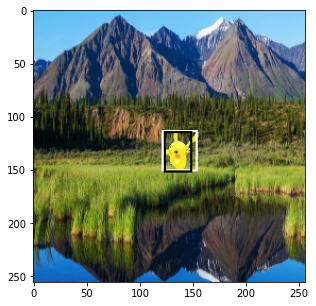

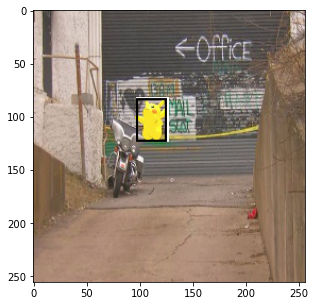

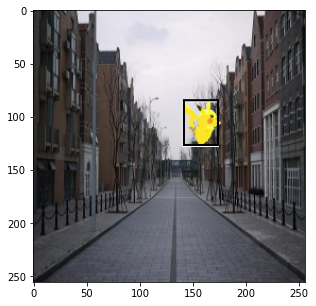

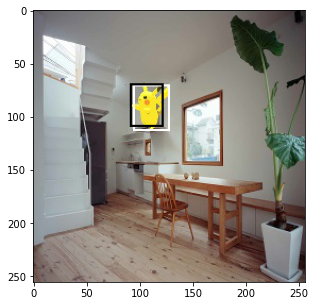

In [7]:
def test():
    loader_test = torch.utils.data.DataLoader(dataset=Dataset(part='test'),
                                              batch_size=4,
                                              shuffle=True,
                                              drop_last=True,
                                              collate_fn=collate_fn)

    for i, (x, y) in enumerate(loader_test):
        break

    model_load = torch.load('./models/自己的实现.model')
    model_load.eval()

    with torch.no_grad():
        outs = model_load(x)

    for i in range(4):
        show(x[i], y[i]['boxes'][0], outs[i])


test()